In [1]:
!pip install -q kaggle

In [2]:
%%bash

mkdir -p ~/.kaggle
cp drive/MyDrive/kaggle.json ~/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download -d hsankesara/flickr-image-dataset

100%|██████████| 8.16G/8.16G [00:43<00:00, 201MB/s]


In [3]:
!unzip flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [4]:
!ls flickr30k_images/

flickr30k_images  results.csv


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
import string
import re
import seaborn as sns
import torchvision
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [6]:
INPUT_IMAGES_DIR = "flickr30k_images/flickr30k_images/"
LABEL_PATH = "flickr30k_images/results.csv"
OUTPUT_PATH = "working"

# Some special tokens for RNN model...
UNK = "#UNK"
PAD = "#PAD"
START = "#START"
END = "#END"

In [7]:
df = pd.read_csv(LABEL_PATH, sep="|")

In [8]:
df.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [9]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
def clean_text(row):
    row = str(row).strip()
    row = row.lower()
    return regex.sub("", row)

In [10]:
df.columns = [col.strip() for col in df.columns]
df["comment"] = df["comment"].apply(clean_text)

In [11]:
df["length"] = df["comment"].apply(lambda row: len(row.strip().split()))
df.head()

,image_name,comment_number,comment,length
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,16
1,1000092795.jpg,1,two young white males are outside near many b...,9
2,1000092795.jpg,2,two men in green shirts are standing in a yard,10
3,1000092795.jpg,3,a man in a blue shirt standing in a garden,10
4,1000092795.jpg,4,two friends enjoy time spent together,6


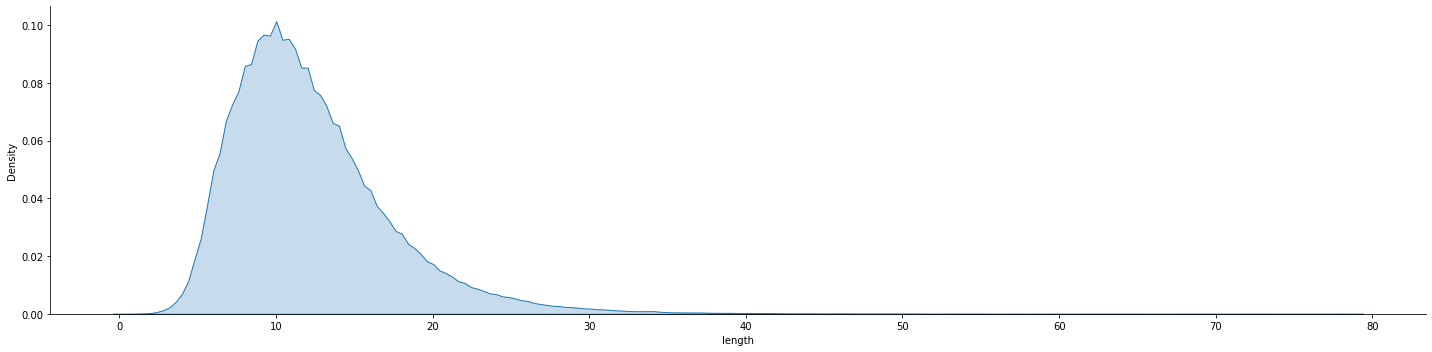

In [12]:
sns.displot(data=df, x='length', palette='mako', kind='kde', fill=True, aspect=4)

In [13]:
captions = df["comment"].tolist()
captions[:10]

['two young guys with shaggy hair look at their hands while hanging out in the yard ',
 'two young  white males are outside near many bushes ',
 'two men in green shirts are standing in a yard ',
 'a man in a blue shirt standing in a garden ',
 'two friends enjoy time spent together ',
 'several men in hard hats are operating a giant pulley system ',
 'workers look down from up above on a piece of equipment ',
 'two men working on a machine wearing hard hats ',
 'four men on top of a tall structure ',
 'three men on a large rig ']

In [14]:
word_freq = {}
for caption in captions:
    caption = caption.strip()
    for word in caption.split():
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1

In [15]:
dict(sorted(word_freq.items(), key=lambda item: item[1])[:30])

{'portrayed': 1,
 'blitz': 1,
 'bieber': 1,
 'urinals': 1,
 'obliverate': 1,
 'uniformly': 1,
 'colleges': 1,
 'meetings': 1,
 '4wheeled': 1,
 'aross': 1,
 'supple': 1,
 'spaceship': 1,
 'decipher': 1,
 'spectrum': 1,
 'month': 1,
 'jail': 1,
 'bandaid': 1,
 'filler': 1,
 'lowly': 1,
 'entrees': 1,
 'hesitates': 1,
 'relatives': 1,
 'moutains': 1,
 'connects': 1,
 'bassoon': 1,
 'explained': 1,
 'somethings': 1,
 'noddles': 1,
 'papayas': 1,
 'septic': 1}

In [16]:
dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:30])

{'a': 271704,
 'in': 83466,
 'the': 62978,
 'on': 45669,
 'and': 44263,
 'man': 42598,
 'is': 41117,
 'of': 38776,
 'with': 36207,
 'woman': 22211,
 'two': 21642,
 'are': 20196,
 'to': 17607,
 'people': 17337,
 'at': 16259,
 'an': 15883,
 'wearing': 15709,
 'young': 13218,
 'white': 13178,
 'shirt': 12981,
 'black': 12311,
 'while': 11711,
 'his': 11495,
 'blue': 11310,
 'red': 9916,
 'girl': 9655,
 'sitting': 9620,
 'men': 9498,
 'boy': 9429,
 'standing': 9113}

In [17]:
def build_vocab(captions, word_freq, count_threshold=5):
    """
    This function builds `vocab` dictionary from list of text captions.
    Also, add constant PAD, UNK, START, END to `vocab`.
    Add a word to vocab if its occurence frequency is larger than `count_threshold`
    
    Parameters
    ----------
    captions: a list of preprocessed text captions above.
    word_freq: a dictionary of word occurence frequency.
    count_threshold: a int to use when building vocab.

    Returns
    -------
    vocab: an dictionary vocabulary of key-value pair which is:
        -> key: string text
        -> value:  token index
    inv_vocab: an inverse dictionary vocabulary of key-value pair which is:
        -> key: token index
        -> value: string text
        
    E.g: vocab = {"two": 4, "young": 5, "guys": 6, ...} 
         inv_vocab = {4: "two", 5: "young", 6: "guys", ...}
    """
    vocab = {
        PAD: 0,
        UNK: 1,
        START: 2,
        END: 3
    }
    index = 4
    
    for caption in captions:
        caption = caption.strip().split(" ")
        for word in caption:
            if word and word_freq[word] >= count_threshold and word not in vocab:
                vocab[word] = index
                index += 1

    inv_vocab = {v: k for k, v in vocab.items()}
    return vocab, inv_vocab

In [18]:
vocab, inv_vocab = build_vocab(captions, word_freq)

In [19]:
def convert_captions(captions, vocab, max_length=30):
    """
    Convert text captions to index token based on `vocab`.
    If a word not in vocab, replace it by the token index of `UNK` constant.
    Also, add `START` constant to the beginning of the sentence and 
            `END` constant to the end of the sentence.
    After add `START` and `END` constant, if the length is still < 30,
        use `PAD` constant to fill remaining positions.
        
    Parameters
    ----------
    captions: a list of preprocessed text captions above.
    vocab: a dictionary vocabulary of key-value pair which is:
        -> key: string text
        -> value: token index
    max_length: an int denotes fixed maximum length to the captions.
    
    Returns
    -------
    tokens: a list of tokens get from `vocab`
    """
    tokens = [[vocab[PAD]]*max_length for _ in range(len(captions))]
    for i, caption in enumerate(captions):
        caption = caption.strip().split()
        tokens[i][0] = vocab[START]
        j = 1
        for word in caption[:max_length-2]:
            if word not in vocab:
                tokens[i][j] = vocab[UNK]
            else:
                tokens[i][j] = vocab[word]
            j += 1
        tokens[i][j] = vocab[END]
    return tokens

In [20]:
tokens = convert_captions(captions, vocab)
img_paths = list(df["image_name"])

In [21]:
class ImageCaptioningDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_paths, tokens):
        """
        img_paths: a list of image path we get from dataframe
        tokens: a list of tokens that we converted from text captions
        """
        self.img_paths = [os.path.join(INPUT_IMAGES_DIR, p) for p in img_paths]
        self.tokens = tokens
        assert len(self.img_paths) == len(self.tokens), "Make sure len(img_paths) == len(tokens)."
    
    def __getitem__(self, index):
        """
        Get image path and token. Then load image path to numpy array image. Convert to pytorch tensor if it's necessary. 
        """
        img_path = self.img_paths[index]
        token = self.tokens[index]
        img = cv2.imread(img_path)
        img = self._resize_img(img, shape=(300, 300))
        img = torchvision.transforms.ToTensor()(img)
        token = torch.as_tensor(token)
        return img, token
    
    def __len__(self):
        return len(self.img_paths)

    def _resize_img(self, img, shape=(300, 300)):
        h, w = img.shape[0], img.shape[1]
        pad_left = 0
        pad_right = 0
        pad_top = 0
        pad_bottom = 0
        if h > w:
            diff = h - w
            pad_top = diff - diff // 2
            pad_bottom = diff // 2
        else:
            diff = w - h
            pad_left = diff - diff // 2
            pad_right = diff // 2
        cropped_img = img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]
        cropped_img = cv2.resize(cropped_img, shape)
        return cropped_img

In [22]:
dataset = ImageCaptioningDataset(img_paths, tokens)

In [23]:
MAX_LENGTH = 30
NUM_VOCAB = len(vocab)
BATCH_SIZE = 128
EPOCH = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
class CNNEncoder(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.cnn = torchvision.models.resnet34(pretrained=True)

    def forward(self, img):
        return self.cnn(img)


In [25]:
class RNNDecoder(nn.Module):

    def __init__(self, num_vocab) -> None:
        super().__init__()
        self.bottleneck = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.num_vocab = num_vocab
        self.embedding = nn.Embedding(num_embeddings=num_vocab, embedding_dim=256, padding_idx=0)
        self.num_layers = 1
        self.bidirectional = False
        self.rnn = nn.LSTM(input_size=256, hidden_size=256, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_vocab)
        )
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input, img_embeded, prediction=False):
        img_embeded = self.bottleneck(img_embeded)
        img_embeded = torch.stack([img_embeded]*(self.num_layers), dim=0)
        if prediction:
            output = []
            hidden = (img_embeded, img_embeded)
            out = input
            while out != vocab[END] and len(output) <= MAX_LENGTH:
                out = torch.tensor([[out]]).to("cuda")
                out = self.embedding(out)
                out, hidden = self.rnn(out, hidden)
                out = self.classifier(out)
                out = self.softmax(out)
                out = torch.argmax(out, dim=-1)
                out = out.squeeze().item()
                output.append(out)
        else:
            input = self.embedding(input)
            output, (h, c) = self.rnn(input, (img_embeded, img_embeded))
            output = self.classifier(output)
        return output

In [26]:
class ImageCaptioningModel:

    def __init__(self, encoder : CNNEncoder, decoder : RNNDecoder, train_dataset : ImageCaptioningDataset):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.encoder = encoder.to(self.device)
        self.encoder.eval()
        self.decoder = decoder.to(self.device)
        self.train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        self.optimizer = optim.Adam(decoder.parameters())
        self.loss = nn.CrossEntropyLoss()

    def predict(self, img):
        with torch.no_grad():
            img_embed = self.encoder(img)
            caption = vocab[START]
            caption = self.decoder(caption, img_embed, prediction=True)
        
        text = [inv_vocab[t] for t in caption]
        text = " ".join(text)
        return text
    
    def train(self):
        for e in range(EPOCH):
            pbar = tqdm(self.train_dataloader, desc="Epoch: {}".format(e+1))
            for i, (img, caption) in enumerate(pbar):
                img = img.to(self.device)
                caption = caption.to(self.device)
                img_embed = self.encoder(img)
                output = self.decoder(caption[:, :-1], img_embed)
                output = output.permute(0, 2, 1)
                loss = self.loss(output, caption[:, 1:])

                self.optimizer.zero_grad()
                loss.backward() 
                self.optimizer.step()

                pbar.set_description(desc="Epoch " + str(e+1) + " - Loss: %.5f" % (loss.item()))
                
                if ((i+1)%100) == 0:
                    plt.imshow(img[-1].cpu().detach().numpy().transpose((1, 2, 0)))
                    output = self.predict(img[-1].unsqueeze(0))
                    plt.title(output)
                    plt.show()

In [27]:
cnn = CNNEncoder()
rnn = RNNDecoder(num_vocab=NUM_VOCAB)
model = ImageCaptioningModel(encoder=cnn, decoder=rnn, train_dataset=dataset)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Epoch 1 - Loss: 2.26636:   8%|▊         | 99/1242 [03:27<37:29,  1.97s/it]

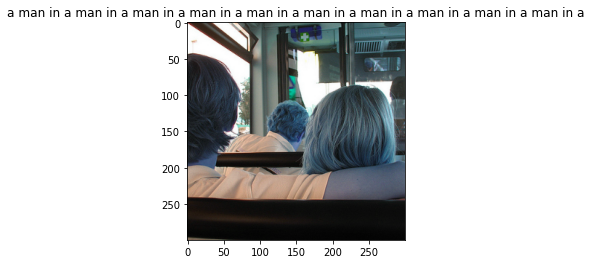

Epoch 1 - Loss: 2.03255:  16%|█▌        | 199/1242 [06:44<33:42,  1.94s/it]

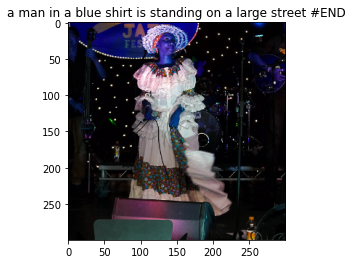

Epoch 1 - Loss: 1.73531:  24%|██▍       | 299/1242 [10:00<31:05,  1.98s/it]

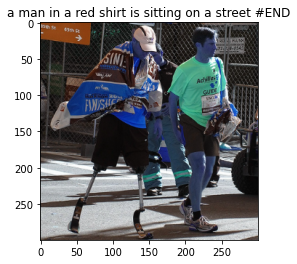

Epoch 1 - Loss: 1.76091:  32%|███▏      | 399/1242 [13:15<27:18,  1.94s/it]

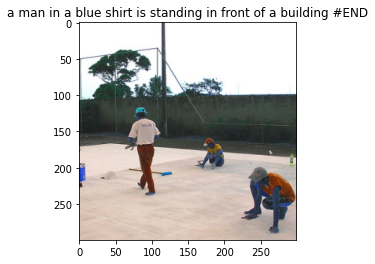

Epoch 1 - Loss: 1.75430:  37%|███▋      | 456/1242 [15:04<25:22,  1.94s/it]

In [ ]:
model.train()